# Code to simulate LMG Model
We have the following Hamiltonian
\begin{align}
H&=-\frac{J}{N}\sum_{i<j}\sigma_{i}^{z}\sigma_{j}^{z}+\gamma\sigma_{i}^{y}\sigma_{j}^{y}-\Gamma\sum_{i}\sigma_{i}^{x}
\end{align}
This reduces to (See ~/Dropbox/Research_Projects_Current/LMG_quench/LMG_quench.lyx),
\begin{equation}
H=-\frac{J}{2}\left(1+\gamma\left(2+\frac{N}{2}\right)\right)-\frac{J\left(2-\gamma\right)}{N}S_{z}^{2}+\frac{J\gamma}{2N}\left(S_{+}^{2}+S_{-}^{2}\right)-\Gamma\left(S_{+}+S_{-}\right)
\end{equation}
with the matrix elements,
\begin{align}
\left\langle S=\frac{N}{2},M\right|H\left|S=\frac{N}{2},M^{\prime}\right\rangle  & =\delta_{MM^{\prime}}\left[-\frac{J}{2}\left(1+\gamma\left(1+\frac{2S\left(S+1\right)}{N}\right)\right)-\frac{J\left(2-\gamma\right)}{N}M^{2}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}-2}\left[\frac{J\gamma}{2N}\sqrt{\left(S\left(S+1\right)-\left(M+2\right)\left(M+1\right)\right)\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}+2}\left[\frac{J\gamma}{2N}\sqrt{\left(S\left(S+1\right)-\left(M-2\right)\left(M-1\right)\right)\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}-1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}+1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]
\end{align}

In [1]:
import numpy as np
from scipy import linalg as LA
import scipy.sparse.linalg as spla
from matplotlib import pyplot as plt
from latex_envs.latex_envs import figcaption
#for Latex font on figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
#define Hamiltonian parameters
class Ham_params:
    def __init__(self, N:int,S:float,J:float,γ:float,Γ:float):
        self.N=N #number of spins, keep it even
        self.S=S #spin sector
        self.J=J #Ising hopping
        self.γ=γ #anisotropy factor
        self.Γ=Γ #Transverse field

In [3]:
#function definitions
def LMG_matrixelement(X:Ham_params,M:float,Mprime:float):
    #computes the matrix element <S,M|H|S,M'>
    value=0 
    if abs(M-Mprime)<10**-5:
        value= (X.J/2)*(1+X.γ*(1-2*X.S*(X.S+1)/X.N))-(M**2)*X.J*(2-X.γ)/X.N
    elif abs(M-(Mprime-2))<10**-5:
        value= X.J*X.γ/(2*X.N)*np.sqrt((X.S*(X.S+1)-(M+2)*(M+1))*(X.S*(X.S+1)-M*(M+1)))
    elif abs(M-(Mprime+2))<10**-5:
        value= X.J*X.γ/(2*X.N)*np.sqrt((X.S*(X.S+1)-(M-2)*(M-1))*(X.S*(X.S+1)-M*(M-1)))
    elif abs(M-(Mprime-1))<10**-5:
        value=-X.Γ*np.sqrt(X.S*(X.S+1)-M*(M+1))
    elif abs(M-(Mprime+1))<10**-5:
        value=-X.Γ*np.sqrt(X.S*(X.S+1)-M*(M-1))
    return value         
def LMG_generateHam(X:Ham_params):
    #Generate (2*S+1,2*S+1) matrix.
    Ham=np.zeros((2*X.N+1,2*X.N+1))
    Marr=np.linspace(-X.N//2,X.N//2,2*X.N+1)
    for p in range(np.size(Marr)):
        for q in range(np.size(Marr)):
            Ham[p,q]=LMG_matrixelement(X,Marr[p],Marr[q])
    return Ham
def magnetization2(state,N):
    #takes in a column vector denoting wavefunction, and calcuates average magnetization as defined for ising spins (See lyx file for def)
    Marr=np.linspace(-N//2,N//2,2*N+1)
    magsq=4/N**2*np.sum(np.square(np.abs(state)*Marr))
    return magsq
def Sz2(state,N):
    #takes in a column vector denoting wavefunction, and calcuates average Sz squared.
    Marr=np.linspace(-N//2,N//2,2*N+1)
    Szsq=np.sum(np.square(np.abs(state)*Marr))
    return Szsq  

In [135]:
paramvals=Ham_params(N=10,S=50,J=1,γ=0.1,Γ=0)
Ham=LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
SEnergies,SEigenvecs=spla.eigs(Ham,k=1,which="SR")#sparse diagonalize
idx = Energies.argsort()  
Energies =Energies[idx]
Eigenvecs = Eigenvecs[:,idx]

(-49.207628913906916+0j)


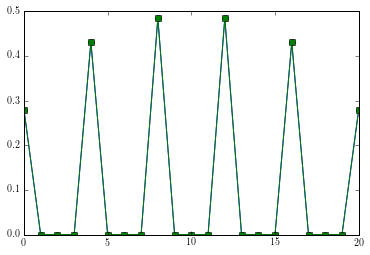

In [186]:
plt.plot(abs(Eigenvecs[:,0]),'-o')
plt.plot(abs(SEigenvecs[:,0]),'-s')
np.disp(Energies[0])

In [5]:
#calculate magnetization as a function of magnetic field
Γarr=np.linspace(0.,2,20)
Larr=np.arange(100,800,100)#choose even
magsqlist=np.ones([np.size(Γarr),np.size(Larr)])
for q in range(np.size(Larr)):
    L=Larr[q]
    for p in range(np.size(Γarr)):
        print([p,q], end='\r', flush=True)
        paramvals=Ham_params(N=L,S=L/2,J=1,γ=0.0,Γ=Γarr[p]) 
        Ham=LMG_generateHam(paramvals)
        GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
        GState=vec[:,0]
        #Energies, Eigenvecs = LA.eig(Ham)
        #GSenergy=Energies[0]
        #GState=Eigenvecs[:,0]
        magsqlist[p,q]=magnetization2(GState,paramvals.N)


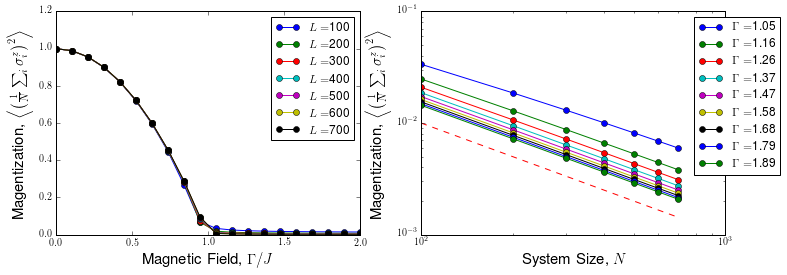

In [12]:
#plotting
α=1 
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(Γarr, magsqlist,'-o')
plt.ylim([0,1.2])
plt.xlabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
plt.ylabel("Magentization, $\\left\\langle\\left(\\frac{1}{N}\\sum_i \\sigma^z_i\\right)^2\\right\\rangle$",fontsize=15)
leg = np.array(['$L=$%d' % p for p in Larr])
plt.legend(leg)
ax=plt.subplot(1,2,2)
plt.loglog(Larr,np.transpose(magsqlist[10:-1,:]),'-o')
plt.loglog(Larr,(Larr.astype(float))**(-α)*(float(Larr[0])**(α)*10**(-2)),'--')
#plt.ylim([0,1.2])
plt.xlabel("System Size, $N$",fontsize=15)
plt.ylabel("Magentization, $\\left\\langle\\left(\\frac{1}{N}\\sum_i \\sigma^z_i\\right)^2\\right\\rangle$",fontsize=15)
leg = np.array(['$\Gamma=$%0.2f' % p for p in Γarr[10:-1]])
plt.legend(leg,bbox_to_anchor=(1.2,1))
figcaption("(a) Magnetization as a function of magnetic field.(b) System size dependence of magnetization. It seems to agree with $N^{-\\alpha}$")

## Phase diagram as a function of the anisotropy.
We would like to recover the phase diagram as a function of the anisotropy parameter $\gamma$. The attempt is to reproduce the Fig.1 in PHYSICAL REVIEW E 78, 021106 (2008). There are four phases depending on the density of states. We would like to obtain for following parameters. In the paper, the Hamiltonian is defined as,
\begin{equation}
H=-\frac{1}{N}(\gamma_x S_x^2+\gamma_yS_y^2)-hS_z
\end{equation}
The different phases parameterized by ($\gamma_x,\gamma_y,h$) are identified as
$I\rightarrow(1/2,1/3,1)
II\rightarrow (2,1/2,1)
III\rightarrow (5,-3,1)
IV \rightarrow(5,3,1)$.

Translating to my notation, $\gamma_x\rightarrow 2J$, $\gamma_y\rightarrow 2J\gamma$, $h\rightarrow 2\Gamma$. And the energies are ofset by a constant $E_{PhysRevE}=E-\frac{J}{2}(1+\gamma)$. So we have the following phases,
\begin{enumerate}
\item $I\rightarrow (J=1/4,\gamma=2/3,\Gamma=1/2)$
\item $II\rightarrow (J=1,\gamma=1/4,\Gamma=1/2)$
\item $III\rightarrow (J=5/2,\gamma=-3/5,\Gamma=1/2)$
\item $IV\rightarrow (J=5/2,\gamma=3/5,\Gamma=1/2)$
\end{enumerate}

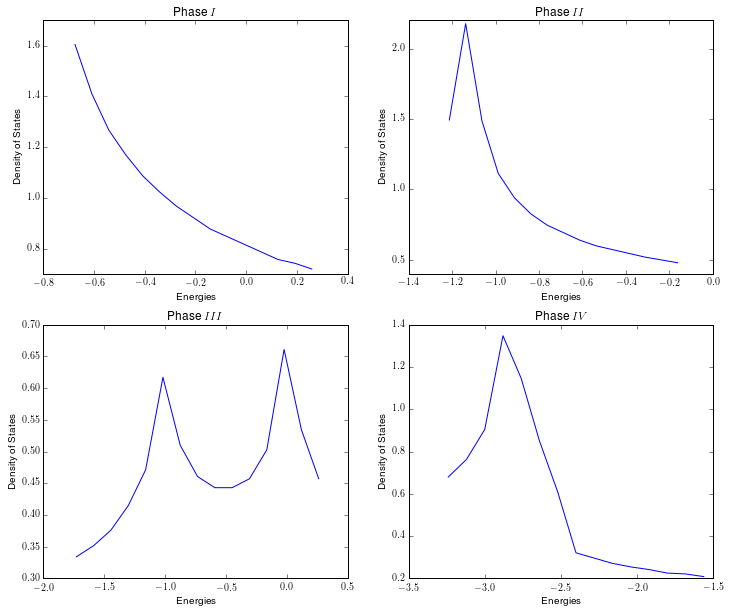

In [17]:
L=2000
plt.figure(figsize=[12,10])
#####Phase I
plt.subplot(2,2,1)
paramvals=Ham_params(N=L,S=L/2,J=1/4,γ=2/3,Γ=1/2)
Ham=LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-1/8*(1+2/3)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $I$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase II
plt.subplot(2,2,2)
paramvals=Ham_params(N=L,S=L/2,J=1,γ=1/4,Γ=1/2)
Ham=LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-1/2*(1+1/4)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $II$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase III
plt.subplot(2,2,3)
paramvals=Ham_params(N=L,S=L/2,J=5/2,γ=-3/5,Γ=1/2)
Ham=LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-5/4*(1-3/5)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $III$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase IV
plt.subplot(2,2,4)
paramvals=Ham_params(N=L,S=L/2,J=5/2,γ=3/5,Γ=1/2)
Ham=LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-5/4*(1+3/5)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $IV$')
plt.xlabel('Energies')
plt.ylabel('Density of States')

\subsection{Quench Protocol-I : Check for thermal properties.}
We start with an initial state and initial Hamiltonian,
\begin{align}
|\psi_{0}\rangle&=\text{Ground state of H_0} \\
H_0&=\text{Far from the critical point, deep in the paramagnetic phase} 
\end{align}
In this section we set $\gamma=0$ to be concurrent with Mohammad's calculations. Later on we will set $\gamma_0\neq 0$ and try to quench from one critical point to other. From that analysis, it is clear that if we quench far from the critical point to a point close to the critical point, it is expected that the output properties are thermal with a temperature, $T=\frac{\omega_0}{4}$ with $\omega_0^2=\frac{\Gamma_0}{J_0}-1$. 

For the numerics we choose the parameters,
\begin{itemize}
\item $H_0\rightarrow J_0=1$, $\gamma_0=0$, $\Gamma_0=4$.
\item $H_f\rightarrow J=1$, $\gamma=0$, $\Gamma=1.02$.
\end{itemize}

In [4]:
L=100 #Set system size.
paramvals0=Ham_params(N=L,S=L/2,J=1,γ=0,Γ=4)
paramvalsf=Ham_params(N=L,S=L/2,J=1,γ=0,Γ=1.02)
dt=0.005 #time step
Tf=200 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [5]:
#Initial state Ground state of the paramagnetic phase
Ham0=LMG_generateHam(paramvals0)
GSenergy,vec=spla.eigs(Ham0,k=1,which="SR")
InitState=vec[:,0]
display("Magnetization of initial state=%f"%magnetization2(InitState,L)) 
display("Total $S_z$=%f"%Sz2(InitState,L))

'Magnetization of initial state=0.011524'

'Total $S_z$=28.808827'

In [7]:
#quench hamiltonian
Hamf=LMG_generateHam(paramvalsf)
GSenergy,vec=spla.eigs(Hamf,k=1,which="SR")
U_dt=LA.expm(-1j*Hamf*dt)

In [9]:
#time-evolved magnetization squared
M2arr=np.zeros(Nsteps)
ψ_t=np.copy(InitState)
for p in np.arange(Nsteps):
    print(p, end='\r', flush=True)
    ψ_t=np.dot(U_dt,ψ_t)
    M2arr[p]=Sz2(ψ_t,L)   

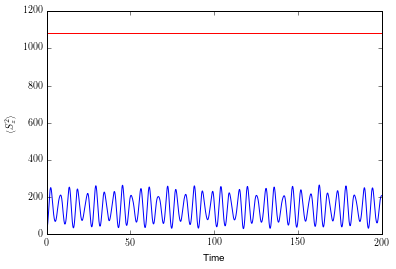

In [14]:
#plotting 
plt.plot(tarr,M2arr)
plt.axhline((L/2)*(paramvals0.Γ-1)**0.5/(4*(paramvalsf.Γ-1)),color='r')
plt.xlabel("Time")
plt.ylabel("$\\langle S_z^2\\rangle$")

In [43]:
np.arange(Nsteps)

array([    0,     1,     2, ..., 39997, 39998, 39999])

In [52]:
paramvals0.Γ

4